In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import collections
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T


from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import pybullet as p

env = KukaDiverseObjectEnv(renders=True, isDiscrete=True, removeHeightHack=False, maxSteps=20,isTest=True,numObjects=5)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

current_dir=C:\Users\chara_eoccfea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pybullet_envs\bullet
cuda


In [3]:
STACK_SIZE = 5

In [4]:
def build_hidden_layer(input_dim, hidden_layers):
    """Build hidden layer.
    Params
    ======
        input_dim (int): Dimension of hidden layer input
        hidden_layers (list(int)): Dimension of hidden layers
    """
    hidden = nn.ModuleList([nn.Linear(input_dim, hidden_layers[0])])
    if len(hidden_layers)>1:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        hidden.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
    return hidden

class ActorCritic(nn.Module):
    def __init__(self,state_size,action_size,shared_layers,
                 critic_hidden_layers=[],actor_hidden_layers=[],
                 seed=0, init_type=None):
        """Initialize parameters and build policy.
        Params
        ======
            state_size (int,int,int): Dimension of each state
            action_size (int): Dimension of each action
            shared_layers (list(int)): Dimension of the shared hidden layers
            critic_hidden_layers (list(int)): Dimension of the critic's hidden layers
            actor_hidden_layers (list(int)): Dimension of the actor's hidden layers
            seed (int): Random seed
            init_type (str): Initialization type
        """
        super(ActorCritic, self).__init__()
        self.init_type = init_type
        self.seed = torch.manual_seed(seed)
        self.sigma = nn.Parameter(torch.zeros(action_size))

        # Add shared hidden layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_size[0])))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_size[1])))
        linear_input_size = convh * convw * 32
        self.shared_layers = build_hidden_layer(input_dim=linear_input_size,
                                                hidden_layers=shared_layers)

        # Add critic layers
        if critic_hidden_layers:
            # Add hidden layers for critic net if critic_hidden_layers is not empty
            self.critic_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                    hidden_layers=critic_hidden_layers)
            self.critic = nn.Linear(critic_hidden_layers[-1], 1)
        else:
            self.critic_hidden = None
            self.critic = nn.Linear(shared_layers[-1], 1)

        # Add actor layers
        if actor_hidden_layers:
            # Add hidden layers for actor net if actor_hidden_layers is not empty
            self.actor_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                   hidden_layers=actor_hidden_layers)
            self.actor = nn.Linear(actor_hidden_layers[-1], action_size)
        else:
            self.actor_hidden = None
            self.actor = nn.Linear(shared_layers[-1], action_size)

        # Apply Tanh() to bound the actions
        self.tanh = nn.Tanh()

        # Initialize hidden and actor-critic layers
        if self.init_type is not None:
            self.shared_layers.apply(self._initialize)
            self.critic.apply(self._initialize)
            self.actor.apply(self._initialize)
            if self.critic_hidden is not None:
                self.critic_hidden.apply(self._initialize)
            if self.actor_hidden is not None:
                self.actor_hidden.apply(self._initialize)

    def _initialize(self, n):
        """Initialize network weights.
        """
        if isinstance(n, nn.Linear):
            if self.init_type=='xavier-uniform':
                nn.init.xavier_uniform_(n.weight.data)
            elif self.init_type=='xavier-normal':
                nn.init.xavier_normal_(n.weight.data)
            elif self.init_type=='kaiming-uniform':
                nn.init.kaiming_uniform_(n.weight.data)
            elif self.init_type=='kaiming-normal':
                nn.init.kaiming_normal_(n.weight.data)
            elif self.init_type=='orthogonal':
                nn.init.orthogonal_(n.weight.data)
            elif self.init_type=='uniform':
                nn.init.uniform_(n.weight.data)
            elif self.init_type=='normal':
                nn.init.normal_(n.weight.data)
            else:
                raise KeyError('initialization type is not found in the set of existing types')

    def forward(self, state):
        """Build a network that maps state -> (action, value)."""
        def apply_multi_layer(layers,x,f=F.leaky_relu):
            for layer in layers:
                x = f(layer(x))
            return x

        state = F.relu(self.bn1(self.conv1(state)))
        state = F.relu(self.bn2(self.conv2(state)))
        state = F.relu(self.bn3(self.conv3(state)))
        state = apply_multi_layer(self.shared_layers,state.view(state.size(0),-1))

        v_hid = state
        if self.critic_hidden is not None:
            v_hid = apply_multi_layer(self.critic_hidden,v_hid)

        a_hid = state
        if self.actor_hidden is not None:
            a_hid = apply_multi_layer(self.actor_hidden,a_hid)

        a = self.tanh(self.actor(a_hid))
        value = self.critic(v_hid).squeeze(-1)
        return a, value

## Input extraction


The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




Number of agents: 1
Size of each action: 7


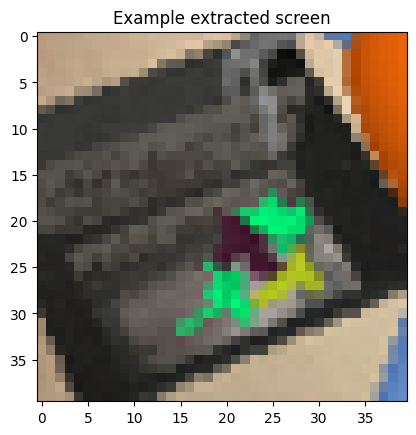

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    #env.render(mode='human')
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()

# number of agents
num_agents = 1
print('Number of agents:', num_agents)

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# size of each action
action_size = env.action_space.n
print('Size of each action:', action_size)

plt.figure()
plt.imshow(init_screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [7]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from pybullet (48, 48, 3).  
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
# n_actions = env.action_space.shapen

policy_net = ActorCritic((screen_height, screen_width, 3), n_actions, [512], [512], [512]).to(device)
target_net = ActorCritic((screen_height, screen_width, 3), n_actions, [512], [512], [512]).to(device)
checkpoint = torch.load('policy_ppo.pt')
print(checkpoint.keys())
policy_net.load_state_dict(checkpoint['policy_state_dict'])
target_net.load_state_dict(checkpoint['optimizer_state_dict'])
# target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

dict_keys(['policy_state_dict', 'optimizer_state_dict', 'epsilon', 'beta'])


RuntimeError: Error(s) in loading state_dict for ActorCritic:
	Unexpected key(s) in state_dict: "shared_layers.1.weight", "shared_layers.1.bias". 
	size mismatch for sigma: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for shared_layers.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for shared_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for critic_hidden.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for critic_hidden.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for critic.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for actor_hidden.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for actor_hidden.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for actor.weight: copying a param with shape torch.Size([3, 64]) from checkpoint, the shape in current model is torch.Size([7, 512]).
	size mismatch for actor.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([7]).

In [ ]:
PATH = 'policy_ppo.pt'

## Evaluation

In [ ]:
episode = 10

# load the model
checkpoint = torch.load(PATH)
policy_net.load_state_dict(checkpoint['policy_state_dict'])
reward_list = []
# evaluate the model
for i_episode in range(episode):
    env.reset()
    state = get_screen()
    stacked_states = collections.deque(STACK_SIZE*[state],maxlen=STACK_SIZE)
    for t in count():
        stacked_states_t =  torch.cat(tuple(stacked_states),dim=1)
        # Select and perform an action
        action = policy_net(stacked_states_t).max(1)[1].view(1, 1)
        _, reward, done, _ = env.step(action.item())
        reward_list.append(reward)
        # Observe new state
        next_state = get_screen()
        stacked_states.append(next_state)
        if done:
            break
    print("Episode: {0:d}, reward: {1}".format(i_episode+1, reward), end="\n")

env.close()

Episode: 1, reward: 0
Episode: 2, reward: 0
Episode: 3, reward: 0
Episode: 4, reward: 0
Green block has been detected
Episode: 5, reward: 1
Episode: 6, reward: 0
Episode: 7, reward: 0
Green block has been detected
Episode: 8, reward: 1
Green block has been detected
Episode: 9, reward: 1
Episode: 10, reward: 0


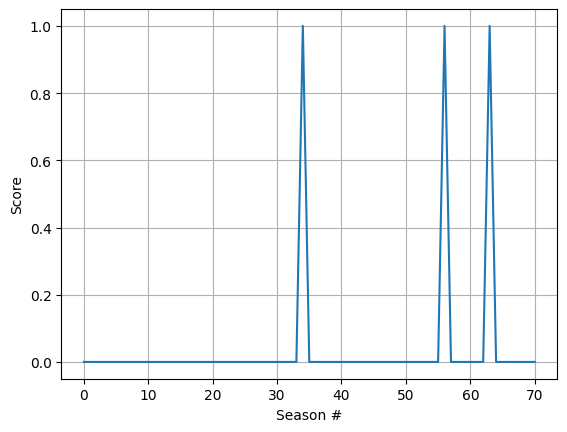

In [ ]:
fig = plt.figure()
plt.plot(np.arange(len(reward_list)), reward_list)
plt.ylabel('Score')
plt.xlabel('Season #')
plt.grid()
plt.show()